In [1]:
%matplotlib inline
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import IPython.display as ipd
import sklearn as sk
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.compose

#models
import sklearn.linear_model
import sklearn.svm
import sklearn.neural_network
import sklearn.ensemble
import sklearn.neighbors

instant                int64
dteday        datetime64[ns]
season              category
yr                     int64
mnth                category
dayofyear            float64
holiday                 bool
weekday             category
workingday              bool
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

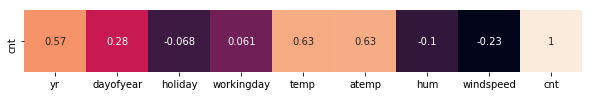

In [2]:
data = pd.read_csv('datasets/bikesharing-day.csv')

data.dteday = pd.to_datetime(data.dteday, format='%Y-%m-%d').dt.normalize()
data.insert(5,'dayofyear', sk.preprocessing.StandardScaler().fit_transform(data.dteday.dt.dayofyear.values.astype(float).reshape(-1, 1)))

data.season = data.season.astype('category')
data.mnth = data.mnth.astype('category')
data.weekday = data.weekday.astype('category')
data.weathersit = data.weathersit.astype('category')
data.holiday = data.holiday.astype(bool)
data.workingday = data.workingday.astype(bool)

ipd.display(data.dtypes)
data.cnt = data.cnt.astype(float)

corrmat = data.drop(columns=['casual', 'registered']).corr()
mpl.pyplot.subplots(figsize=(10, 5))
sns.heatmap(corrmat.iloc[[-1],1:], vmax=.8, cbar=None, square=True,annot=True)
mpl.pyplot.show()

categorical_columns = set(['season','mnth','weekday','weathersit'])

In [3]:
def onehotfy(variates, predict=None):
    columns = variates + [predict] if predict else variates
    dataset = data.loc[:, columns]
    dummies = [pd.get_dummies(dataset[cc], cc) for cc in categorical_columns.intersection(variates)]
    return pd.concat([dataset.drop(columns=categorical_columns.intersection(variates)), *dummies], axis=1)

def regression_models(variates, predict, transform=True, models=[]):
    dataset = onehotfy(variates, predict)
    def regression_model(model, curr_split, param_grid=None):
        name = type(model[0] if type(model) is tuple else model).__name__
        train_index, test_index = curr_split
        trainX = dataset.loc[train_index, :].drop(columns=predict)
        testX  = dataset.loc[test_index , :].drop(columns=predict)

        trainy = dataset.loc[train_index, [predict]]
        testy  = dataset.loc[test_index , [predict]]

        if transform:
            ss = sk.preprocessing.StandardScaler()
#             ct = sk.preprocessing.StandardScaler()
#             trainX = ct.fit_transform(trainX);
            trainy = ss.fit_transform(trainy)
#             testX = ct.transform(testX)

        if type(model) is tuple:
            rgs = sk.model_selection.GridSearchCV(model[0], param_grid=model[1], cv=5, n_jobs=-1, verbose=0, iid=False)
            model = rgs
        else:
            model = sk.base.clone(model)

        model.fit(trainX,trainy.ravel())
        predictedy = model.predict(testX)
        if transform:
            predictedy = ss.inverse_transform(predictedy)
        return pd.Series({
            'RMSE': np.sqrt(sk.metrics.mean_squared_error(testy,predictedy)),
            'MAE': sk.metrics.mean_absolute_error(testy,predictedy),
            'model': (model, ss)
        }, name=name)
    
    k = 5
    outer = sk.model_selection.KFold(k)
    runs = pd.concat([pd.DataFrame([regression_model(m,split) for m in models]) for split in outer.split(dataset)], keys=range(0,k)).swaplevel()
    
    results = runs.mean(level=0)
    results['model and scalers'] = runs['model'].loc[runs['RMSE'].groupby(level=0).idxmin()].reset_index(level=1, drop=True)
    return results.sort_values('RMSE')

In [4]:
# variates = ['dayofyear', 'yr', 'workingday', 'weathersit', 'atemp', 'windspeed']
variates = ['dayofyear','yr']
results = regression_models(variates, 'cnt', models=[
    sk.linear_model.LinearRegression(),
    (sk.svm.SVR(), {
       'C': np.logspace(-1, 1, 5), 'gamma': np.logspace(-1, 1, 5)
    }),
    (sk.neural_network.MLPRegressor(solver='lbfgs',hidden_layer_sizes=(100,50), max_iter=2000),{
        'alpha': np.logspace(-1,-5,5),
    }),
    sklearn.ensemble.GradientBoostingRegressor()
])

# Colunas

['dayofyear', 'yr']

# Erro médio das rodada

,RMSE,MAE
SVR,1102.776267,839.944099
GradientBoostingRegressor,1622.920307,1298.105321
LinearRegression,1896.130315,1613.391402
MLPRegressor,2330.114429,1865.580232


# Melhores modelos

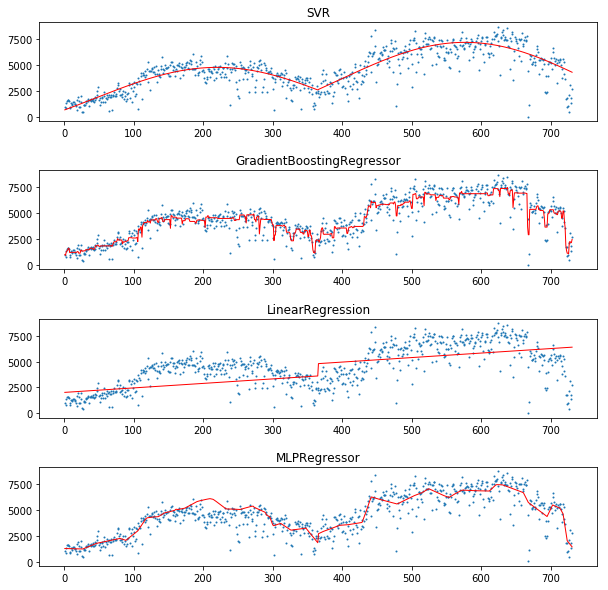

In [5]:
ipd.display(ipd.Markdown(r'# Colunas'))
ipd.display(variates)
ipd.display(ipd.Markdown(r'# Erro médio das rodada'))
ipd.display(results.drop(columns='model and scalers'))
ipd.display(ipd.Markdown(r'# Melhores modelos'))
_, axs = mpl.pyplot.subplots(len(results),1, figsize=(10,10))
mpl.pyplot.subplots_adjust(hspace=0.5)

# xpoints = #sc.transform(data.loc[:,variates])
xpoints = data.loc[:,'instant']

for ax in axs:
    ax.scatter(xpoints,data.loc[:,'cnt'], s=1)
i = 0
for k,(m,s) in results.loc[:,'model and scalers'].iteritems():
    axs[i].plot(xpoints, s.inverse_transform(m.predict(onehotfy(variates))), color='red', linewidth=1)
    axs[i].set_title(k)
    i += 1

In [6]:
variates = ['dayofyear', 'yr', 'workingday', 'weathersit', 'atemp', 'windspeed']
results = regression_models(variates, 'cnt', models=[
    sk.linear_model.LinearRegression(),
    (sk.svm.SVR(), {
       'C': np.logspace(-1, 1, 5), 'gamma': np.logspace(-1, 1, 5)
    }),
    (sk.neural_network.MLPRegressor(solver='lbfgs',hidden_layer_sizes=(100,50), max_iter=2000),{
        'alpha': np.logspace(-1,-5,5),
    }),
    sklearn.ensemble.GradientBoostingRegressor()
])

# Colunas

['dayofyear', 'yr', 'workingday', 'weathersit', 'atemp', 'windspeed']

# Erro médio das rodada

,RMSE,MAE
LinearRegression,1017.093921,798.372010
GradientBoostingRegressor,1019.855129,813.472412
SVR,1211.437198,997.097706
MLPRegressor,1572.990326,1266.490388


# Melhores modelos

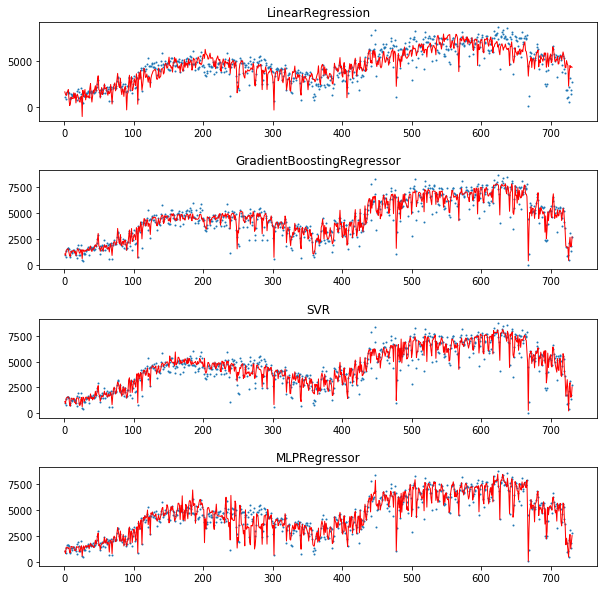

In [7]:
ipd.display(ipd.Markdown(r'# Colunas'))
ipd.display(variates)
ipd.display(ipd.Markdown(r'# Erro médio das rodada'))
ipd.display(results.drop(columns='model and scalers'))
ipd.display(ipd.Markdown(r'# Melhores modelos'))
_, axs = mpl.pyplot.subplots(len(results),1, figsize=(10,10))
mpl.pyplot.subplots_adjust(hspace=0.5)

# xpoints = #sc.transform(data.loc[:,variates])
xpoints = data.loc[:,'instant']

for ax in axs:
    ax.scatter(xpoints,data.loc[:,'cnt'], s=1)
i = 0
for k,(m,s) in results.loc[:,'model and scalers'].iteritems():
    axs[i].plot(xpoints, s.inverse_transform(m.predict(onehotfy(variates))), color='red', linewidth=1)
    axs[i].set_title(k)
    i += 1

In [8]:
del results

In [9]:
def classification_models(variates, predict, transform=True, models=[]):
    variates = list(data.columns.drop([predict, 'instant', 'dteday']))
    dataset = onehotfy(variates, predict)
    def classification_model(model, curr_split, param_grid=None):
        name = type(model[0] if type(model) is tuple else model).__name__
        train_index, test_index = curr_split
        trainX = dataset.loc[train_index, :].drop(columns=predict)
        testX  = dataset.loc[test_index , :].drop(columns=predict)

        trainy = dataset.loc[train_index, [predict]]
        testy  = dataset.loc[test_index , [predict]]

        if transform:
            pass

        if type(model) is tuple:
            rgs = sk.model_selection.GridSearchCV(model[0], param_grid=model[1], cv=5, n_jobs=-1, verbose=0, iid=False)
            model = rgs
        else:
            model = sk.base.clone(model)

        model.fit(trainX,trainy.values.ravel())
        predictedy = model.predict(testX)
        return pd.Series({
            'ACC': np.sqrt(sk.metrics.accuracy_score(testy,predictedy)),
            'model': model
        }, name=name)
    
    k = 5
    outer = sk.model_selection.KFold(k)
    runs = pd.concat([pd.DataFrame([classification_model(m,split) for m in models]) for split in outer.split(dataset)], keys=range(0,k)).swaplevel()
    
    results = runs.mean(level=0)
    results['model and scalers'] = runs['model'].loc[runs['ACC'].groupby(level=0).idxmax()].reset_index(level=1, drop=True)
    return results.sort_values('ACC')

In [12]:
predict = 'workingday'
variates = list(data.columns.drop([predict, 'instant', 'dteday']))
results = classification_models(variates, predict, models=[
    sk.linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=5000),
    sk.neighbors.KNeighborsClassifier(),
    sk.svm.SVC(gamma='scale'),
    sk.ensemble.GradientBoostingClassifier(),
])

# Colunas

['season',
 'yr',
 'mnth',
 'dayofyear',
 'holiday',
 'weekday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

# Acurácia médio das rodada

,ACC
SVC,0.899270
KNeighborsClassifier,0.920466
LogisticRegression,0.993105
GradientBoostingClassifier,1.000000


# Matrizes de Confusão

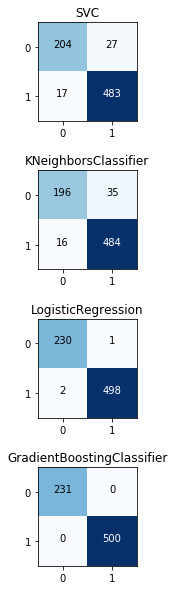

In [13]:
def plot_confusion_matrix(ax, cm, classes, normalize=False):
    cmap=mpl.pyplot.cm.Blues
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

ipd.display(ipd.Markdown(r'# Colunas'))
ipd.display(variates)
ipd.display(ipd.Markdown(r'# Acurácia médio das rodada'))
ipd.display(results.drop(columns='model and scalers'))
ipd.display(ipd.Markdown(r'# Matrizes de Confusão'))
_, axs = mpl.pyplot.subplots(len(results),1, figsize=(10,10))
mpl.pyplot.subplots_adjust(hspace=0.5)
i = 0
for k,m in results.loc[:,'model and scalers'].iteritems():
    cm = sk.metrics.confusion_matrix(data.loc[:,predict], m.predict(onehotfy(variates)))
    plot_confusion_matrix(axs[i],cm, data.loc[:,predict].unique())
#     axs[i].plot(xpoints, s.inverse_transform(m.predict(onehotfy(variates))), color='red', linewidth=1)
    axs[i].set_title(k)
    i += 1